In [24]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [25]:
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [26]:
base_path = "data"
words_list = []

words = open("/Users/vishwas/Desktop/build_my_web/data/words.txt", "r").readlines()
for line in words:
    if line[0]=='#':
        continue
    if line.split(" ")[1]!="err": # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

96456

In [27]:
np.random.shuffle(words_list)
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [28]:
base_image_path = "/Users/vishwas/Desktop/build_my_web/data/words"
def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        
        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0] 
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path =  os.path.join(base_image_path, partI, 
            partI + "-" + partII,
            image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])
#         print(file_line,"..",image_name,"..",partI,"..",partII,"..",img_path)
#         break
    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)


In [29]:
print(train_img_paths[0],"__", train_labels[0])

/Users/vishwas/Desktop/build_my_web/data/words/e04/e04-030/e04-030-04-08.png __ e04-030-04-08 ok 170 1489 1499 120 39 JJ sure


In [30]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size(alpha+num+punch): ", len(characters))
print(len(train_labels_cleaned))
characters

Maximum length:  21
Vocab size(alpha+num+punch):  78
86808


{'!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [31]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [32]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
AUTOTUNE = tf.data.AUTOTUNE

In [33]:
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


In [34]:
x=tf.constant(
[[77],
 [58],
 [20],
 [56],
 [27],
 [56],
 [62]])
num_to_char(x)

<tf.Tensor: shape=(7, 1), dtype=string, numpy=
array([[b'&'],
       [b'q'],
       [b'A'],
       [b'I'],
       [b'c'],
       [b'I'],
       [b'p']], dtype=object)>

In [35]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image  = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
                  [pad_height_top, pad_height_bottom],
                  [pad_width_left, pad_width_right],
                  [0, 0]
                ]
        )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [36]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    #creats a something like generator and applies a funtion for each element (.map)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    #batch is like grouping into buckets 
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [37]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

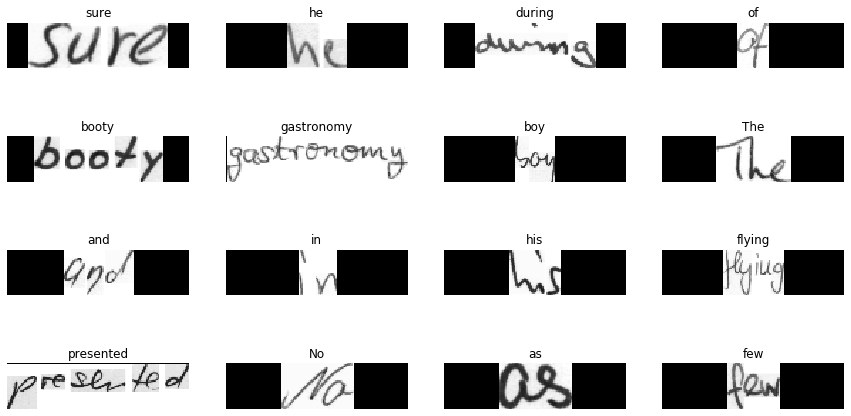

In [38]:
#Creates a Dataset with at most count elements from this dataset. - 
#take(1) takes first data from dataset
#take(5) takes first 5 datas from dataset
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= 99.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()


In [39]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None,**kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
#         super(CustomLayer, self).__init__(name=name)
#         self.k = k
        super(CTCLayer, self).__init__(**kwargs)

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img =  keras.Input(
        shape=(image_width, image_height, 1), name="image")
    labels =  keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x =  keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x =  keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x =  keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x =  keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x =  keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x =  keras.layers.Dropout(0.2)(x)

    # RNNs.
    x =  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x =  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer (the tokenizer is char-level)
    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x =  keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)
    
    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model =  keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 32, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 16, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 64, 16, 64)   18496       pool1[0][0]                      
_____________________________________________________________________________

In [40]:
# epochs = 5 # To get good results this should be at least 50.

# # Train the model
# model = build_model()
# history = model.fit(
#     train_ds,
#     validation_data=validation_ds,
#     epochs=epochs,
# )
# model.save('model.h5')

In [41]:
# from keras.models import model_from_json
# from keras.models import load_model

# # serialize model to JSON
# #  the keras model which is trained is defined as 'model' in this example
# model_json = model.to_json()


# with open("model_num.json", "w") as json_file:
#     json_file.write(model_json)

# # serialize weights to HDF5
# model.save_weights("model_num.h5")

In [42]:
# prediction_model = keras.models.Model(
#     model.get_layer(name="image").input, model.get_layer(name="dense2").output
# )
# def decode_batch_predictions(pred):
#     input_len = np.ones(pred.shape[0]) * pred.shape[1]
#     # Use greedy search. For complex tasks, you can use beam search.
#     results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
#         :, :max_len
#     ]
#     # Iterate over the results and get back the text.
#     output_text = []
#     for res in results:
#         res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
#         res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
#         output_text.append(res)
#     return output_text


# #  Let's check results on some test samples.
# for batch in test_ds.take(1):
#     batch_images = batch["image"]
#     _, ax = plt.subplots(4, 4, figsize=(15, 8))

#     preds = prediction_model.predict(batch_images)
#     pred_texts = decode_batch_predictions(preds)

#     for i in range(16):
#         img = batch_images[i]
#         img = tf.image.flip_left_right(img)
#         img = tf.transpose(img, perm=[1, 0, 2])
#         img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
#         img = img[:, :, 0]

#         title = f"Prediction: {pred_texts[i]}"
#         ax[i // 4, i % 4].imshow(img, cmap="gray")
#         ax[i // 4, i % 4].set_title(title)
#         ax[i // 4, i % 4].axis("off")

# plt.show()

In [43]:
new_model = tf.keras.models.load_model('model.h5', custom_objects={'CTCLayer': CTCLayer})

tf.Tensor(
[[77]
 [58]
 [20]
 [56]
 [27]
 [56]
 [62]], shape=(7, 1), dtype=int64)
tf.Tensor(
[[33]
 [56]
 [27]
 [56]], shape=(4, 1), dtype=int64)
tf.Tensor([[69]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[20]
 [70]
 [56]], shape=(3, 1), dtype=int64)
tf.Tensor(
[[60]
 [20]], shape=(2, 1), dtype=int64)
tf.Tensor([[31]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[77]
 [58]
 [11]
 [56]], shape=(4, 1), dtype=int64)
tf.Tensor(
[[45]
 [70]
 [56]], shape=(3, 1), dtype=int64)
tf.Tensor(
[[11]
 [76]
 [59]
 [42]
 [20]
 [59]
 [76]
 [ 6]], shape=(8, 1), dtype=int64)
tf.Tensor(
[[42]
 [43]
 [43]
 [77]
 [58]
 [43]
 [20]
 [56]
 [62]], shape=(9, 1), dtype=int64)
tf.Tensor(
[[77]
 [63]
 [63]
 [59]
 [43]
 [43]
 [ 6]
 [21]
 [42]], shape=(9, 1), dtype=int64)
tf.Tensor(
[[20]
 [76]], shape=(2, 1), dtype=int64)
tf.Tensor(
[[61]
 [20]
 [56]], shape=(3, 1), dtype=int64)
tf.Tensor(
[[78]
 [77]
 [31]
 [20]
 [56]
 [62]], shape=(6, 1), dtype=int64)
tf.Tensor([[69]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[18]
 [27]
 [

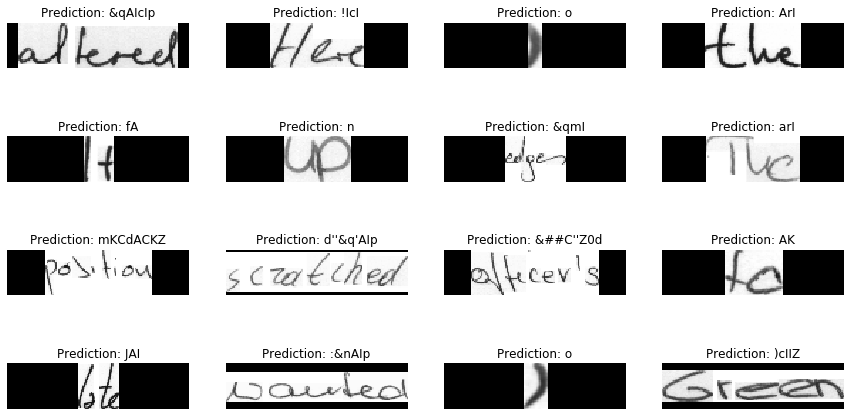

In [52]:
prediction_model = keras.models.Model(
    new_model.get_layer(name="image").input, new_model.get_layer(name="dense2").output
)
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        print(res)
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    with open('/Users/vishwas/Desktop/bd/model.txt', 'w') as f:
        f.write(str(output_text))
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [45]:
# loaded_model = load_model('my_model.h5', custom_objects={'CTCLayer': CTCLayer})
# # load weights into new model
# loaded_model.load_weights("model_num.h5")
# print("Loaded model from disk")

# # loaded_model.save('model_num.hdf5')

# # loaded_model=load_model('model_num.hdf5')

In [46]:
# # %%capture cap --no-stderr
# c=model.weights

In [47]:
# c=model.weights
# with open('model.txt', 'w') as f:
#     f.write(str(c))

In [48]:
# prediction_model = keras.models.Model(
#     model.get_layer(name="image").input, model.get_layer(name="dense2").output
# )
# model_json = prediction_model.to_json()


# with open("model_num.json", "w") as json_file:
#     json_file.write(model_json)

# # serialize weights to HDF5
# prediction_model.save_weights("model_num.h5")

# loaded_model = load_model('my_model.h5', custom_objects={'CTCLayer': CTCLayer})
# # load weights into new model
# loaded_model.load_weights("model_num.h5")
# print("Loaded model from disk")

# # loaded_model.save('model_num.hdf5')
# # loaded_model=load_model('model_num.hdf5')

# loaded_model.summary()
# def decode_batch_predictions(pred):
#     input_len = np.ones(pred.shape[0]) * pred.shape[1]
#     # Use greedy search. For complex tasks, you can use beam search.
#     results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
#         :, :max_len
#     ]
#     # Iterate over the results and get back the text.
#     output_text = []
#     for res in results:
#         res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
#         res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
#         output_text.append(res)
#     return output_text


# #  Let's check results on some test samples.
# for batch in test_ds.take(1):
#     batch_images = batch["image"]
#     _, ax = plt.subplots(4, 4, figsize=(15, 8))

#     preds = loaded_model.predict(batch_images)
#     pred_texts = decode_batch_predictions(preds)

#     for i in range(16):
#         img = batch_images[i]
#         img = tf.image.flip_left_right(img)
#         img = tf.transpose(img, perm=[1, 0, 2])
#         img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
#         img = img[:, :, 0]

#         title = f"Prediction: {pred_texts[i]}"
#         ax[i // 4, i % 4].imshow(img, cmap="gray")
#         ax[i // 4, i % 4].set_title(title)
#         ax[i // 4, i % 4].axis("off")

# plt.show()

In [49]:
# model.save('my_model.h5')

In [50]:
# model.get_weights()

In [51]:
# from tensorflow import keras
# load_model = keras.models.load_model('my_model.h5')
f

NameError: name 'f' is not defined

In [ ]:
from keras.models import load_model
# Assuming your model includes instance of an "AttentionLayer" class
l_m = load_model('my_model.h5', custom_objects={'CTCLayer': CTCLayer})

In [ ]:
model.save('model.tf')
# new_model = tf.keras.models.load_model('model.tf')

In [ ]:
new_model = tf.keras.models.load_model('model.tf')

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

In [ ]:
prediction_model.save("prediction_model.tf")

In [ ]:
prediction_model.save("prediction_model.h5")

In [ ]:
load_prediction_model = keras.models.load_model('prediction_model.h5')

In [ ]:
load_1model = keras.models.load_model('my_model.h5')

In [ ]:
model.save_weights('my_model_weights.h5')

In [ ]:
json_string = model.to_json()
open('my_model_architecture.json', 'w').write(json_string)

In [ ]:
from keras.models import Sequential,model_from_json
model1 = model_from_json(open('my_model_architecture.json').read())

model1.load_weights('my_model_weights.h5')

In [ ]:
model.save('model.hdf5')

In [ ]:
new_model.summary()

In [ ]:
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_final.h5")

print("Saved model to disk")

In [ ]:
son_file = open('model_final.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_modelxx = build_model()
# loaded_modelxx.summary()
loaded_modelxx.load_weights("model_final.h5")
print("Loaded model from disk")

In [ ]:
model.save_weights("model_final.hdf5")

In [ ]:
model.save("m")

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()


In [ ]:
prediction_model.save_weights("prediction_model.h5")
prediction_model.save_weights("prediction_model.hdf5")

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
ok_final = build_model()
# loaded_modelxx.summary()
ok_final.load_weights("model_final.h5")
print("Loaded model from disk")
ok_final_prediction_model = keras.models.Model(
    ok_final.get_layer(name="image").input, ok_final.get_layer(name="dense2").output
)


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = ok_final_prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
# modle.save_weigh

In [ ]:
ok_final = build_model()
# loaded_modelxx.summary()
ok_final.load_weights("model_final.h5")
print("Loaded model from disk")
ok_final_prediction_model = keras.models.Model(
    ok_final.get_layer(name="image").input, ok_final.get_layer(name="dense2").output
)


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = ok_final_prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
model_json = model.to_json()
with open("model_last.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_last.h5")
print("Saved model to disk")